In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import(accuracy_score, roc_auc_score, f1_score, plot_confusion_matrix,
                            recall_score, confusion_matrix, precision_score, classification_report)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import display, HTML

#global variable
random_state=42

%matplotlib inline

In [6]:
df=pd.read_csv('./data/churn.csv').drop(columns=['RowNumber','Surname', 'CustomerId', 'Geography'], axis=1)
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
df['Gender']=df['Gender'].apply(lambda x: 0 if x=='Female' else 1)

In [8]:
y = df["Exited"]
X = df.drop(["Exited"], axis = 1)

In [9]:
y.shape, X.shape

((10000,), (10000, 9))

In [10]:
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy score can be misleading. In a dataset with highly unbalanced classes, the classifier will always “predicts” the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.

## Data splitting

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=random_state)

It is important to train the models on a different subset
of the training data than the linear regression model to avoid
overfitting, in particular if the total number of leaves is
similar to the number of training samples.

In [12]:
X_train_set, X_val, y_train_set, y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_set)
X_train_set=scaler.transform(X_train_set)#train set scaled

In [14]:
X_val=scaler.transform(X_val)#validation set scaled

In [15]:
X_test=scaler.transform(X_test)#original dataset scaled

# Modeling 

- XGBoost
- Logistic Classifier
- AdaBoost Classifier
- GradientBoosting Classifier
- Decision Tree Classifier
- Random Forest Classifier
- KNN Classifier

Skewed datasets are not uncommon. And they are tough to handle. Usual classification models and techniques often fail miserably when presented with such a problem. Although your model could get you to even a 99% accuracy on such cases, yet, if you are measuring yourself against a sensible metric such as the ROC Auc score, then you will face trouble getting up that leaderboard. This is because if the dataset is skewed, for example, a 10:1 ratio of Positives to Negatives occur, then by just predicting positives for every sample you see without any learning, you can get to a 90% accuracy score! So, how do we get around this problem? This post will highlight a few effective techniques you can use to do well on such tasks. The techniques range from differently sampling your data to setting some hyperparameters cleverly to using libraries that contain different versions of the usual algorithms which internally handle imbalance themselves.

## Sampling/undersampling not changing perfmomance. (see SMOT/NOT SMOT notebook)

##  XGBoost

Although the algorithm performs well in general, even on imbalanced classification datasets, it offers a way to tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution.

This modified version of XGBoost is referred to as Class Weighted XGBoost or Cost-Sensitive XGBoost and can offer better performance on binary classification problems with a severe class imbalance.

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.84950


## hypoparameter tuned for scewed data. 

In [17]:
# count examples in each class
from collections import Counter
counter = Counter(y_train_set)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 3.860


In [18]:
y_train_set.value_counts()

0    5083
1    1317
Name: Exited, dtype: int64

In [19]:
model = XGBClassifier(scale_pos_weight=4,random_state=random_state)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))


Mean ROC AUC: 0.84780


Not much improvement with that settings. 0.84949 with parameter tuned and 84950 without. will grid search a range of different class weightings for class-weighted XGBoost and discover which results in the best ROC AUC score.

In [20]:

 # define grid
param_grid= {'scale_pos_weight':[1,2,3], 'n_estimators':[50,100,300,500]}
model= XGBClassifier()

In [21]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train_set, y_train_set)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.849496 using {'n_estimators': 100, 'scale_pos_weight': 1}
0.846361 (0.015445) with: {'n_estimators': 50, 'scale_pos_weight': 1}
0.846979 (0.015424) with: {'n_estimators': 50, 'scale_pos_weight': 2}
0.847772 (0.015406) with: {'n_estimators': 50, 'scale_pos_weight': 3}
0.849496 (0.015662) with: {'n_estimators': 100, 'scale_pos_weight': 1}
0.848253 (0.015474) with: {'n_estimators': 100, 'scale_pos_weight': 2}
0.848781 (0.015883) with: {'n_estimators': 100, 'scale_pos_weight': 3}
0.846732 (0.015914) with: {'n_estimators': 300, 'scale_pos_weight': 1}
0.844310 (0.016411) with: {'n_estimators': 300, 'scale_pos_weight': 2}
0.843372 (0.017150) with: {'n_estimators': 300, 'scale_pos_weight': 3}
0.840776 (0.017038) with: {'n_estimators': 500, 'scale_pos_weight': 1}
0.838463 (0.017495) with: {'n_estimators': 500, 'scale_pos_weight': 2}
0.837429 (0.017859) with: {'n_estimators': 500, 'scale_pos_weight': 3}


In this case, we can see that the scale_pos_weight=1 positive class weighting achieved the best mean ROC score. This matches the configuration for the general heuristic.

In [22]:
xgbc= XGBClassifier(scale_pos_weight=3, subsample=0.5, random_state=random_state)
xgbc.fit(X_train_set, y_train_set)
y_pred=xgbc.predict(X_val)

In [23]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1273
           1       0.54      0.71      0.61       327

    accuracy                           0.82      1600
   macro avg       0.73      0.78      0.75      1600
weighted avg       0.84      0.82      0.83      1600



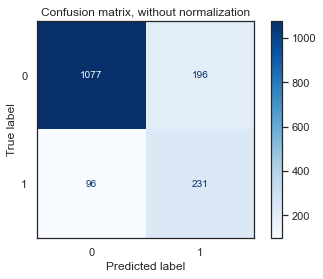

In [24]:
disp = plot_confusion_matrix(xgbc, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## KNeighborsClassifier (5)

In [25]:
from sklearn import neighbors
# define model
model = neighbors.KNeighborsClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.75912 


In [26]:
kncl= neighbors.KNeighborsClassifier()
kncl.fit(X_train_set, y_train_set)
y_pred=kncl.predict(X_val)

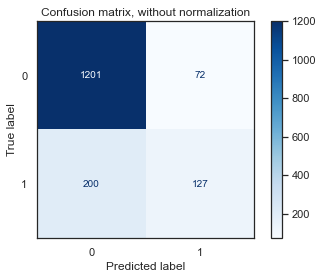

In [27]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(kncl, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

In [28]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1273
           1       0.64      0.39      0.48       327

    accuracy                           0.83      1600
   macro avg       0.75      0.67      0.69      1600
weighted avg       0.81      0.83      0.81      1600



## Logistic Regression

In [29]:
# define model
model = LogisticRegression()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.74513 


In [30]:
logit = LogisticRegression()
logit.fit(X_train_set, y_train_set)
y_pred=logit.predict(X_val)

In [31]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1273
           1       0.55      0.17      0.26       327

    accuracy                           0.80      1600
   macro avg       0.68      0.57      0.57      1600
weighted avg       0.76      0.80      0.76      1600



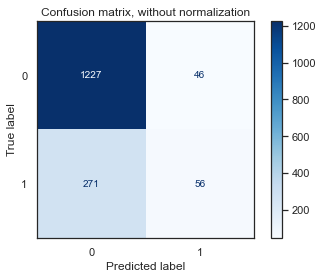

In [32]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(logit, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## DecisionTreeClassifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.66639 


In [34]:
tree = DecisionTreeClassifier()
tree.fit(X_train_set, y_train_set)
y_pred=tree.predict(X_val)

In [35]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1273
           1       0.45      0.50      0.48       327

    accuracy                           0.77      1600
   macro avg       0.66      0.67      0.67      1600
weighted avg       0.78      0.77      0.78      1600



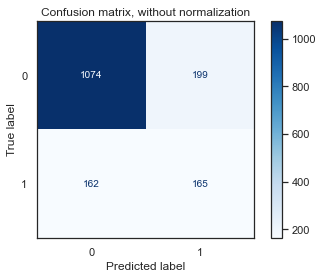

In [36]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(tree, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## RandomForestClassifier 

In [37]:
from sklearn.ensemble import RandomForestClassifier
# define model
model = RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=5, random_state=random_state)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.84047 


## Tuning

In [38]:
# define grid
param_grid= {'n_estimators':[50,100,200],'max_depth':[None,3,5]}
model =RandomForestClassifier(class_weight={0: 1, 1: 3},random_state=random_state)

In [39]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train_set, y_train_set)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.841638 using {'max_depth': 5, 'n_estimators': 200}
0.826318 (0.019496) with: {'max_depth': None, 'n_estimators': 50}
0.830168 (0.018316) with: {'max_depth': None, 'n_estimators': 100}
0.831876 (0.016840) with: {'max_depth': None, 'n_estimators': 200}
0.821885 (0.015797) with: {'max_depth': 3, 'n_estimators': 50}
0.823305 (0.015969) with: {'max_depth': 3, 'n_estimators': 100}
0.825933 (0.015903) with: {'max_depth': 3, 'n_estimators': 200}
0.839137 (0.014862) with: {'max_depth': 5, 'n_estimators': 50}
0.840469 (0.014114) with: {'max_depth': 5, 'n_estimators': 100}
0.841638 (0.014187) with: {'max_depth': 5, 'n_estimators': 200}


In [40]:
rf= RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=200, max_depth=5, random_state=random_state)
rf.fit(X_train_set, y_train_set)
y_pred=rf.predict(X_val)

In [41]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1273
           1       0.58      0.63      0.60       327

    accuracy                           0.83      1600
   macro avg       0.74      0.76      0.75      1600
weighted avg       0.84      0.83      0.83      1600



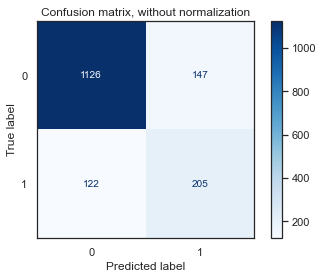

In [42]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(rf, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## GradientBoostingClassifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
# define model
model = GradientBoostingClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.84724 


## Tuning
### Fix learning rate and number of estimators for tuning tree-based parameters

In [44]:
# define grid
param_grid_1 = {'validation_fraction':[0.1,0.3],'n_iter_no_change':[20,50],'learning_rate':[0.5, 0.1]}
model = GradientBoostingClassifier(random_state=random_state)

In [45]:
# define evaluation procedure
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid_1, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train_set, y_train_set)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.846630 using {'learning_rate': 0.1, 'n_iter_no_change': 20, 'validation_fraction': 0.1}
0.839979 (0.015785) with: {'learning_rate': 0.5, 'n_iter_no_change': 20, 'validation_fraction': 0.1}
0.836444 (0.016858) with: {'learning_rate': 0.5, 'n_iter_no_change': 20, 'validation_fraction': 0.3}
0.833162 (0.016168) with: {'learning_rate': 0.5, 'n_iter_no_change': 50, 'validation_fraction': 0.1}
0.827176 (0.018584) with: {'learning_rate': 0.5, 'n_iter_no_change': 50, 'validation_fraction': 0.3}
0.846630 (0.015449) with: {'learning_rate': 0.1, 'n_iter_no_change': 20, 'validation_fraction': 0.1}
0.844712 (0.016289) with: {'learning_rate': 0.1, 'n_iter_no_change': 20, 'validation_fraction': 0.3}
0.846453 (0.015621) with: {'learning_rate': 0.1, 'n_iter_no_change': 50, 'validation_fraction': 0.1}
0.844040 (0.016458) with: {'learning_rate': 0.1, 'n_iter_no_change': 50, 'validation_fraction': 0.3}


In [46]:
gb_clf=GradientBoostingClassifier(learning_rate=0.1, n_iter_no_change=20, validation_fraction=0.1)
gb_clf.fit(X_train_set, y_train_set)
y_pred=gb_clf.predict(X_val)

In [47]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1273
           1       0.74      0.45      0.56       327

    accuracy                           0.86      1600
   macro avg       0.81      0.71      0.74      1600
weighted avg       0.85      0.86      0.84      1600



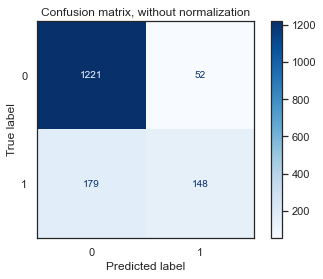

In [48]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(gb_clf, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## ADA Boost

In [49]:
from sklearn.ensemble import AdaBoostClassifier
# define model
model=AdaBoostClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_set, y_train_set, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.5f' % mean(scores))
print("Mean ROC AUC: %.5f " % (scores.mean()))

Mean ROC AUC: 0.83496 


In [50]:
ada=AdaBoostClassifier()
ada.fit(X_train_set, y_train_set)
y_pred=ada.predict(X_val)

In [51]:
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1273
           1       0.70      0.46      0.55       327

    accuracy                           0.85      1600
   macro avg       0.79      0.70      0.73      1600
weighted avg       0.84      0.85      0.84      1600



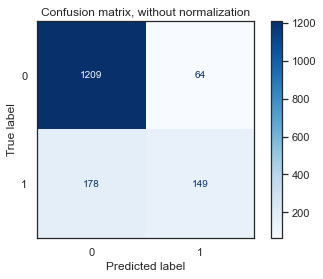

In [52]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(ada, X_val, y_val,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

## Holdout set

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=200, max_depth=5, random_state=42)
y_pred=rf.fit(X_train_set, y_train_set).predict(X_test)
print(rf.predict_proba(X_test))

[[0.79428298 0.20571702]
 [0.74608236 0.25391764]
 [0.58981701 0.41018299]
 ...
 [0.20257165 0.79742835]
 [0.66793877 0.33206123]
 [0.66794359 0.33205641]]


In [55]:
rf_class_report=classification_report(y_test, y_pred, digits=2)
print(rf_class_report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.56      0.66      0.61       393

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000



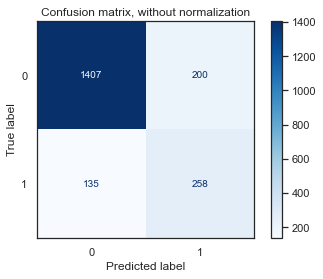

In [56]:
disp = plot_confusion_matrix(rf, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

In [57]:
rf_matrix=confusion_matrix(y_test, y_pred)
print(rf_matrix)

[[1407  200]
 [ 135  258]]


# Gradient Boost

In [63]:
gb_clf=GradientBoostingClassifier(learning_rate=0.1, n_iter_no_change=20, validation_fraction=0.1)
y_pred=gb_clf.fit(X_train_set, y_train_set).predict(X_test)
print(gb_clf.predict_proba(X_test))

[[0.946785   0.053215  ]
 [0.96159694 0.03840306]
 [0.89673568 0.10326432]
 ...
 [0.2556816  0.7443184 ]
 [0.87033419 0.12966581]
 [0.84961753 0.15038247]]


In [64]:
gb_clf_class_report=classification_report(y_test, y_pred, digits=2)
print(gb_clf_class_report)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.46      0.56       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



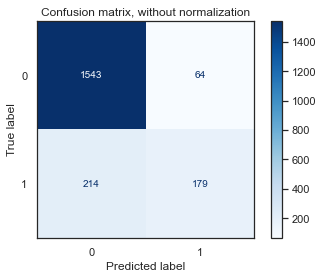

In [65]:
disp = plot_confusion_matrix(gb_clf, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

In [66]:
gb_clf_matrix=confusion_matrix(y_test, y_pred)
print(gb_clf_matrix)

[[1543   64]
 [ 214  179]]


## XGBC

In [67]:
xgbc= XGBClassifier(scale_pos_weight=3, subsample=0.5, random_state=random_state)
y_pred=xgbc.fit(X_train_set, y_train_set).predict(X_test)
print(xgbc.predict_proba(X_test))

[[0.91255736 0.08744263]
 [0.85594296 0.14405702]
 [0.63940096 0.36059904]
 ...
 [0.09517884 0.90482116]
 [0.7279419  0.27205816]
 [0.5623862  0.4376138 ]]


In [69]:
xgbc_class_report=classification_report(y_test, y_pred, digits=2)
print(xgbc_class_report)

              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1607
           1       0.51      0.70      0.59       393

    accuracy                           0.81      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.84      0.81      0.82      2000



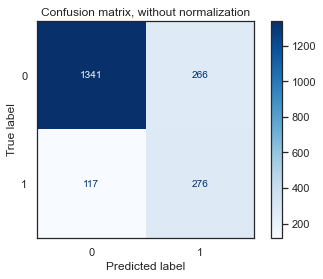

In [70]:
disp = plot_confusion_matrix(xgbc, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()

In [71]:
xgbc_matrix=confusion_matrix(y_test, y_pred)
print(xgbc_matrix)

[[1341  266]
 [ 117  276]]


# ROC_AUC score(cross-validation)

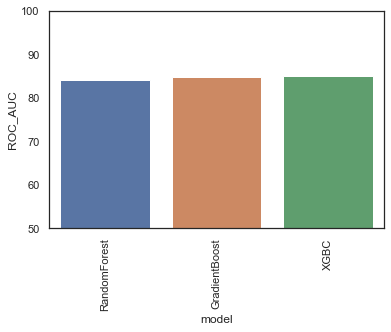

In [85]:
models = ['RandomForest','GradientBoost', 'XGBC']
cv_scores  = [84.16, 84.72, 84.94]
results = pd.DataFrame({'model': models, 'ROC_AUC': cv_scores})

ax = sns.barplot(x='model', y='ROC_AUC', data=results)
ax.set_ylim([50,100])
plt.xticks(rotation=90)
plt.show();

#display(results)

## Classification Report  NO SMOT

In [82]:
#classification_report
print("\nrandom forest classification report\n")
print(rf_class_report)
print("\ngradient boost classification report\n")
print(gb_clf_class_report)
print("\nxgb classification report\n")
print(xgbc_class_report)


random forest classification report

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1607
           1       0.56      0.66      0.61       393

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.84      2000


gradient boost classification report

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.46      0.56       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000


xgb classification report

              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1607
           1       0.51      0.70      0.59       393

    accuracy                           0.81      2000
   macro avg       0.71

## Confusion Matrix 

In [89]:
#confusion matrix
print("\nrandom forest confusion matrix\n")
print(rf_matrix)
print("\ngradient boost confusion matrix\n")
print(gb_clf_matrix)
print("\nxgb confusion matrix\n")
print(xgbc_matrix)


random forest confusion matrix

[[1407  200]
 [ 135  258]]

gradient boost confusion matrix

[[1543   64]
 [ 214  179]]

xgb confusion matrix

[[1341  266]
 [ 117  276]]


## My choice fall on XGBC

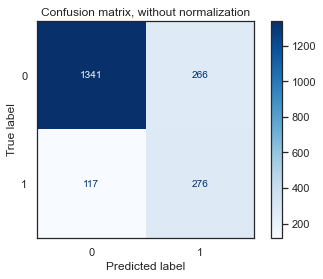

<Figure size 432x288 with 0 Axes>

In [88]:
disp = plot_confusion_matrix(xgbc, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")
plt.show()
plt.savefig('XGBCNoSMOT')

In [94]:
scaler = StandardScaler()
df_array = scaler.fit_transform(df)

In [95]:
scaled_df = pd.DataFrame(df_array, columns = df.columns)

In [96]:
sampled = scaled_df.sample(1000,random_state=1010)
Counter(sampled.Exited)

Counter({-0.5057747646140591: 796, 1.9771646787539288: 204})

In [98]:
mask_0  = sampled.Exited < 0
mask_1  = sampled.Exited > 0